# Leg 2: News Model Training

This notebook is an optimized version of `02_train_leg2_news.ipynb`


**Optimizations**:
1. **Device**: Uses `mps` (Metal Performance Shaders) for GPU acceleration
2. **Batch Size**: Increased to 128
3. **Epochs**: Increased to 10
4. **Data Loading**: Increased `num_workers` to 8 and enabled `pin_memory`

**Workflow**:
1. Load preprocessed news data
2. Wrap the PyTorch model (`Leg2HANWrapper`) with MPS support
3. Run Walk-Forward Cross-Validation
4. Save raw OOF predictions (`/kaggle/working/leg2_oof_preds.pkl`)
5. Evaluate raw performance

In [4]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import kagglehub
from datetime import datetime

# --- 1. Clone Repository ---
REPO_URL = "https://github.com/brianrp09232000/multimodal-eq-sizing.git"
REPO_DIR = "/kaggle/working/multimodal-eq-sizing"

if not os.path.exists(REPO_DIR):
    print(f"Cloning {REPO_URL} into {REPO_DIR}...")
    !git clone {REPO_URL} {REPO_DIR}
else:
    print("Repository already exists. Pulling latest changes...")
    !cd {REPO_DIR} && git pull

# --- 2. CRITICAL FIX: Uninstall TensorFlow ---
# Kaggle GPU kernels come with TensorFlow, which conflicts with the 
# protobuf version needed by PyTorch/Transformers in this setup.
# We uninstall it to prevent the "ImportError: runtime_version" crash.
print("Uninstalling TensorFlow components...")
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-metadata

# --- 3. Fix Protobuf & Install Requirements ---
print("Fixing protobuf version...")
!pip install "protobuf==3.20.3" 

# --- 4. Setup Paths ---
src_path = os.path.join(REPO_DIR, "src")
if os.path.exists(src_path):
    if src_path not in sys.path:
        sys.path.append(src_path)

# --- 5. Project Imports ---
try:
    from src.models.HAN_l2 import FinbertHAN
    from src.data.loaders import NewsDataset, han_collate_fn
    from src.utils.cv import generate_yearly_oof
except ImportError:
    from models.HAN_l2 import FinbertHAN
    from data.loaders import NewsDataset, han_collate_fn
    from utils.cv import generate_yearly_oof

# --- 6. Device Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("✅ Using CUDA acceleration")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ Using CPU")

# Config
SEED = 42
BATCH_SIZE = 128 
EPOCHS = 10 
LR = 1e-4
MAX_GRAD_NORM = 1.0
NUM_WORKERS = 3 # Reduced from 8 to prevent warnings on T4
PIN_MEMORY = True

torch.manual_seed(SEED)
np.random.seed(SEED)

Repository already exists. Pulling latest changes...
Already up to date.
Uninstalling TensorFlow components...
Fixing protobuf version...
✅ Using CUDA acceleration


## 1. Define Model Wrapper

We update the wrapper to use `pin_memory` and `NUM_WORKERS` in the DataLoader.

In [5]:
class Leg2HANWrapper:
    """
    Scikit-learn compatible wrapper for the FinbertHAN PyTorch model
    Produces raw regression outputs
    Optimized for Apple Silicon via DataLoader params
    """
    def __init__(self, 
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS, 
                 lr=LR, 
                 device=DEVICE):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.device = device
        self.model = None
        self.train_loss_history = []

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # Prepare data
        train_df = X.copy()
        if y is not None:
            train_df['target'] = y.values
        
        dataset = NewsDataset(train_df)
        loader = DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            collate_fn=han_collate_fn,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY
        )

        self.model = FinbertHAN(aux_dim=4).to(self.device)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)
        criterion = nn.MSELoss()

        self.model.train()
        self.train_loss_history = []

        for epoch in range(self.epochs):
            epoch_loss = 0.0
            count = 0
            for batch in loader:
                input_ids = batch['input_ids'].to(self.device)
                att_mask = batch['attention_mask'].to(self.device)
                doc_lens = batch['doc_lengths']
                time_gaps = batch['time_gaps'].to(self.device)
                aux_feats = batch['aux_features'].to(self.device)
                news_mask = batch['news_mask'].to(self.device)
                targets = batch['targets'].to(self.device)

                optimizer.zero_grad()
                preds, _, _ = self.model(input_ids, att_mask, doc_lens, time_gaps, aux_feats, news_mask)
                loss = criterion(preds, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), MAX_GRAD_NORM)
                optimizer.step()

                epoch_loss += loss.item() * targets.size(0)
                count += targets.size(0)
            
            avg_loss = epoch_loss / max(1, count)
            self.train_loss_history.append(avg_loss)
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {avg_loss:.6f}")
        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self.model.eval()
        test_df = X.copy()
        if 'target' not in test_df.columns:
            test_df['target'] = 0.0 
            
        dataset = NewsDataset(test_df)
        loader = DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=han_collate_fn,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY
        )

        all_preds = []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(self.device)
                att_mask = batch['attention_mask'].to(self.device)
                doc_lens = batch['doc_lengths']
                time_gaps = batch['time_gaps'].to(self.device)
                aux_feats = batch['aux_features'].to(self.device)
                news_mask = batch['news_mask'].to(self.device)
                preds, _, _ = self.model(input_ids, att_mask, doc_lens, time_gaps, aux_feats, news_mask)
                all_preds.append(preds.cpu().numpy())
        
        return np.concatenate(all_preds).flatten()

## 2. Load Data

Same loading logic as the standard notebook.

In [6]:
# Define search directories for Kaggle
SEARCH_DIRS = [
    "/kaggle/input", 
    "/kaggle/working", 
    "../src/data/datasets" # Fallback for local
]

def find_file(filename, search_dirs):
    print(f"Searching for {filename}...")
    for directory in search_dirs:
        # Check direct path
        path = Path(directory) / filename
        if path.exists():
            return path
        # Check recursive
        if Path(directory).exists():
            try:
                matches = list(Path(directory).rglob(filename))
                if matches:
                    return matches[0]
            except Exception as e:
                print(f"Access error in {directory}: {e}")
    return None

NEWS_FILENAME = "filtered_news_dataset.csv"
PRICES_FILENAME = "prices_dataset.csv"

NEWS_PATH = find_file(NEWS_FILENAME, SEARCH_DIRS)
PRICES_PATH = find_file(PRICES_FILENAME, SEARCH_DIRS)

def robust_literal_eval(val):
    if pd.isna(val) or val == "" or str(val).lower() == 'nan':
        return []
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [str(val)]

if NEWS_PATH:
    print(f"Loading News from {NEWS_PATH}...")
    news_converters = {
        'sentences': robust_literal_eval,
        'Article_title': robust_literal_eval,
        'entities': robust_literal_eval,
        'entities_today': robust_literal_eval
    }
    df_news = pd.read_csv(NEWS_PATH, converters=news_converters)
    
    if 'sentences' in df_news.columns and 'Article_title' not in df_news.columns:
        df_news = df_news.rename(columns={'sentences': 'Article_title'})
    if 'Stock_symbol' in df_news.columns and 'ticker' not in df_news.columns:
        df_news = df_news.rename(columns={'Stock_symbol': 'ticker'})
    df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True)
    print(f"News Loaded. Shape: {df_news.shape}.")
else:
    raise FileNotFoundError(f"News file not found in {SEARCH_DIRS}")


if PRICES_PATH:
    print(f"Loading Prices from {PRICES_PATH}...")
    df_prices = pd.read_csv(PRICES_PATH)
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], utc=True)
    print(f"Prices Loaded. Shape: {df_prices.shape}")
else:
    raise FileNotFoundError(f"Prices file not found in {SEARCH_DIRS}")

df_full = pd.merge(df_prices, df_news, on=['Date', 'ticker'], how='left')
df_full = df_full.sort_values('Date').reset_index(drop=True)

target_col = 'next_day_excess_return'

if target_col in df_full.columns:
    df_full = df_full.dropna(subset=[target_col])
    X = df_full.drop(columns=[target_col])
    y = df_full[target_col]
    dates = df_full['Date']
    print(f"Data Ready. Final Shape: {df_full.shape}")
else:
    raise KeyError(f"Target column '{target_col}' not found.")

Searching for filtered_news_dataset.csv...
Searching for prices_dataset.csv...
Loading News from /kaggle/input/nasdaq-news/filtered_news_dataset.csv...
News Loaded. Shape: (802424, 4).
Loading Prices from /kaggle/input/nasdaq-news/prices_dataset.csv...
Prices Loaded. Shape: (391686, 30)
Data Ready. Final Shape: (523959, 32)


## 3. Walk-Forward Cross Validation (OOF Generation)

Uses `generate_yearly_oof` with the optimized factory.

In [7]:
# Define the optimized model factory
def model_factory():
    return Leg2HANWrapper(batch_size=BATCH_SIZE, epochs=EPOCHS, lr=LR, device=DEVICE)

# Run OOF Generation
# We rely on the speedup inside the model training for performance gains
if 'X' in locals():
    oof_preds_raw, oof_targets, fold_stats = generate_yearly_oof(
        model_factory=model_factory,
        X=X,
        y=y,
        dates=dates,
        min_train_years=2,
        n_jobs=1 
    )
    
    print(f"OOF Prediction Complete. Generated {len(oof_preds_raw)} predictions.")
    print(pd.DataFrame(fold_stats))

Starting yearly walk-forward CV: 7 folds scheduled
First fold val year: 2012
Last fold val year: 2018


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.001106
Epoch 2/10 - Loss: 0.000519
Epoch 3/10 - Loss: 0.000392
Epoch 4/10 - Loss: 0.000314
Epoch 5/10 - Loss: 0.000286
Epoch 6/10 - Loss: 0.000269
Epoch 7/10 - Loss: 0.000259
Epoch 8/10 - Loss: 0.000252
Epoch 9/10 - Loss: 0.000248
Epoch 10/10 - Loss: 0.000245


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.001082
Epoch 2/10 - Loss: 0.000423
Epoch 3/10 - Loss: 0.000301
Epoch 4/10 - Loss: 0.000263
Epoch 5/10 - Loss: 0.000248
Epoch 6/10 - Loss: 0.000241
Epoch 7/10 - Loss: 0.000237
Epoch 8/10 - Loss: 0.000236
Epoch 9/10 - Loss: 0.000234
Epoch 10/10 - Loss: 0.000234


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.001026
Epoch 2/10 - Loss: 0.000320
Epoch 3/10 - Loss: 0.000249
Epoch 4/10 - Loss: 0.000229
Epoch 5/10 - Loss: 0.000222
Epoch 6/10 - Loss: 0.000220
Epoch 7/10 - Loss: 0.000218
Epoch 8/10 - Loss: 0.000218
Epoch 9/10 - Loss: 0.000217
Epoch 10/10 - Loss: 0.000217


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.001219
Epoch 2/10 - Loss: 0.000292
Epoch 3/10 - Loss: 0.000229
Epoch 4/10 - Loss: 0.000216
Epoch 5/10 - Loss: 0.000212
Epoch 6/10 - Loss: 0.000211
Epoch 7/10 - Loss: 0.000210
Epoch 8/10 - Loss: 0.000210
Epoch 9/10 - Loss: 0.000210
Epoch 10/10 - Loss: 0.000210


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.001040
Epoch 2/10 - Loss: 0.000262
Epoch 3/10 - Loss: 0.000226
Epoch 4/10 - Loss: 0.000219
Epoch 5/10 - Loss: 0.000218
Epoch 6/10 - Loss: 0.000217
Epoch 7/10 - Loss: 0.000217
Epoch 8/10 - Loss: 0.000217
Epoch 9/10 - Loss: 0.000217
Epoch 10/10 - Loss: 0.000217


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.000809
Epoch 2/10 - Loss: 0.000252
Epoch 3/10 - Loss: 0.000234
Epoch 4/10 - Loss: 0.000231
Epoch 5/10 - Loss: 0.000230
Epoch 6/10 - Loss: 0.000230
Epoch 7/10 - Loss: 0.000230
Epoch 8/10 - Loss: 0.000230
Epoch 9/10 - Loss: 0.000230
Epoch 10/10 - Loss: 0.000230


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.000945
Epoch 2/10 - Loss: 0.000244
Epoch 3/10 - Loss: 0.000230
Epoch 4/10 - Loss: 0.000229
Epoch 5/10 - Loss: 0.000228
Epoch 6/10 - Loss: 0.000228
Epoch 7/10 - Loss: 0.000228
Epoch 8/10 - Loss: 0.000228
Epoch 9/10 - Loss: 0.000228
Epoch 10/10 - Loss: 0.000228
OOF Prediction Complete. Generated 437942 predictions.
   val_year train_years  n_train  n_val
0      2012   2010-2011    86017  46362
1      2013   2010-2012   132379  50902
2      2014   2010-2013   183281  55653
3      2015   2010-2014   238934  59625
4      2016   2010-2015   298559  67463
5      2017   2010-2016   366022  81010
6      2018   2010-2017   447032  76927


## 4. Save Raw OOF Predictions

Saves to `/kaggle/working/leg2_oof_preds.pkl` - this will overwrite any existing file

In [8]:
if 'oof_preds_raw' in locals() and len(oof_preds_raw) > 0:
    # 1. Reconstruct Metadata (Date, ticker)
    unique_years = sorted(dates.dt.year.unique())
    min_train_years = 2
    val_years = unique_years[min_train_years:]
    
    oof_dfs = []
    
    for val_year in val_years:
        val_mask = dates.dt.year == val_year
        subset = df_full.loc[val_mask, ['Date', 'ticker', target_col]].copy()
        oof_dfs.append(subset)
        
    oof_df = pd.concat(oof_dfs)
    oof_df['prediction'] = oof_preds_raw
    
    print(f"OOF Metadata Shape: {oof_df.shape}")
    print(f"OOF Preds Length: {len(oof_preds_raw)}")
    assert len(oof_df) == len(oof_preds_raw), "Mismatch between OOF metadata and predictions length"
    
    # 3. Save to Kaggle Working Directory
    SAVE_PATH = "/kaggle/working/leg2_oof_preds.pkl"
    if not os.access(os.path.dirname(SAVE_PATH), os.W_OK):
        # Fallback to local
        SAVE_PATH = "../data/leg2_oof_preds.pkl"
    
    os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
    
    oof_df.to_pickle(SAVE_PATH)
    print(f"Saved OOF predictions to: {SAVE_PATH}")
    print(oof_df.head())

OOF Metadata Shape: (437942, 4)
OOF Preds Length: 437942
Saved OOF predictions to: /kaggle/working/leg2_oof_preds.pkl
                           Date ticker  next_day_excess_return  prediction
86017 2012-01-03 00:00:00+00:00     EA               -0.043230    0.000000
86018 2012-01-03 00:00:00+00:00    CRM               -0.019185   -0.004685
86019 2012-01-03 00:00:00+00:00   TMUS               -0.052632    0.000000
86020 2012-01-03 00:00:00+00:00   PAYX               -0.012458    0.000000
86021 2012-01-03 00:00:00+00:00    PSA               -0.027277    0.000000


## 5. Raw Performance Metrics

Leg 2 Results
MSE Raw: 0.000231
IC Raw: -0.0014


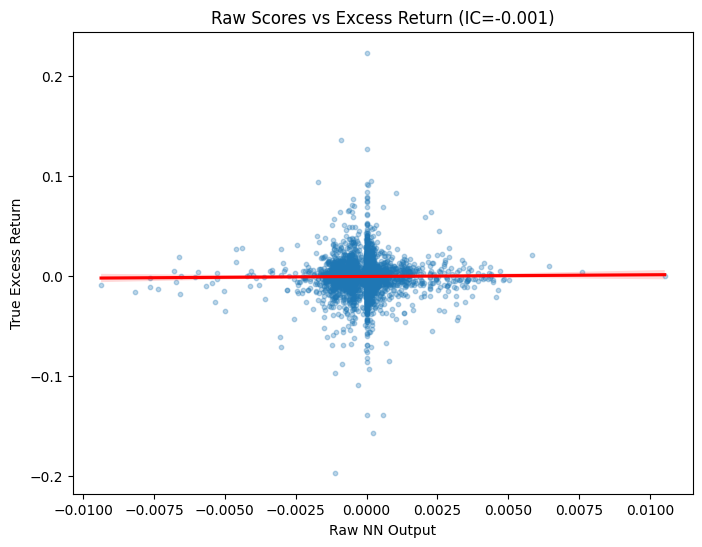

In [9]:
if 'oof_preds_raw' in locals() and len(oof_preds_raw) > 0:
    mse_raw = mean_squared_error(oof_targets, oof_preds_raw)
    ic_raw, _ = pearsonr(oof_preds_raw, oof_targets)
    
    print(f"Leg 2 Results")
    print(f"MSE Raw: {mse_raw:.6f}")
    print(f"IC Raw: {ic_raw:.4f}")
    
    plt.figure(figsize=(8, 6))
    indices = np.random.choice(len(oof_targets), min(5000, len(oof_targets)), replace=False)
    
    sns.regplot(x=oof_preds_raw[indices], y=oof_targets[indices], 
                scatter_kws={'alpha':0.3, 's': 10}, line_kws={'color':'red'})
    plt.title(f"Raw Scores vs Excess Return (IC={ic_raw:.3f})")
    plt.xlabel("Raw NN Output")
    plt.ylabel("True Excess Return")
    plt.show()

In [10]:
handle = "iinarixf0x/leg2-news-model"
local_dataset_dir = f"/kaggle/working/"
current_date = datetime.today().strftime("%Y-%m-%d")

try:
    kagglehub.dataset_upload(handle, local_dataset_dir, version_notes=f"Dataset {current_date}")
    print("Upload successful")
except Exception as e:
    print(f"Upload failed: {e}")

Uploading Dataset https://www.kaggle.com/datasets/iinarixf0x/leg2-news-model ...
More than 50 files detected, creating a zip archive...
Starting upload for file /tmp/tmpsgxdgcv7/archive.zip


Uploading: 100%|██████████| 14.9M/14.9M [00:00<00:00, 27.8MB/s]

Upload successful: /tmp/tmpsgxdgcv7/archive.zip (14MB)


Your dataset has been created.
Files are being processed...
See at: https://www.kaggle.com/datasets/iinarixf0x/leg2-news-model
Upload successful
